<a href="https://colab.research.google.com/github/zenca/Forecasting/blob/main/Forecasting_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting ARIMA

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import pandas as pd
import statsmodels.api as sm
import warnings

In [ ]:
datos = sm.datasets.co2.load_pandas()#Uso este data que lo trae ya el stamodel y tiene index date
datos1 = datos.data
datos1# tiene separación por semana.

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4
...,...
2001-12-01,370.3
2001-12-08,370.8
2001-12-15,371.2
2001-12-22,371.3


In [ ]:
datos1.info()#Hay unos cuantos null

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2284 entries, 1958-03-29 to 2001-12-29
Freq: W-SAT
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   co2     2225 non-null   float64
dtypes: float64(1)
memory usage: 35.7 KB


In [ ]:
datos1 =datos1['co2'].resample('MS').mean()#Separo por mes
datos1

1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01           NaN
1958-07-01    315.625000
                 ...    
2001-08-01    369.425000
2001-09-01    367.880000
2001-10-01    368.050000
2001-11-01    369.375000
2001-12-01    371.020000
Freq: MS, Name: co2, Length: 526, dtype: float64

In [ ]:
datos1=datos1.fillna(datos1.bfill())#Rellleno los nan con el anterior
datos1# me lo rellenó con el posterior? bue

1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01    315.625000
1958-07-01    315.625000
                 ...    
2001-08-01    369.425000
2001-09-01    367.880000
2001-10-01    368.050000
2001-11-01    369.375000
2001-12-01    371.020000
Freq: MS, Name: co2, Length: 526, dtype: float64

In [ ]:
datos2=pd.DataFrame(datos1)
datos2.info()#Me achicó porque la hice mensual.

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 526 entries, 1958-03-01 to 2001-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   co2     526 non-null    float64
dtypes: float64(1)
memory usage: 8.2 KB


In [ ]:
datos2.head()

,co2
1958-03-01,316.100000
1958-04-01,317.200000
1958-05-01,317.433333
1958-06-01,315.625000
1958-07-01,315.625000


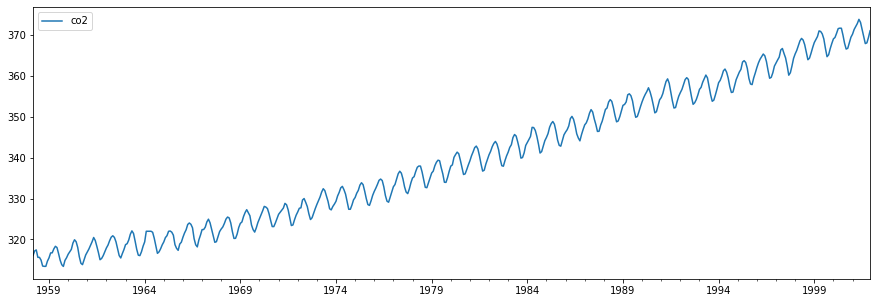

In [ ]:
datos2.plot(figsize=(15,5))

In [ ]:
datos2.columns

Index(['co2'], dtype='object')

In [ ]:
#Grafico por mes
"""datos2['year'] = [d.year for d in datos2]
datos2['month'] = [d.strftime('%b') for d in datos2]
years = datos2['year'].unique()
datos2.head()"""


"datos2['year'] = [d.year for d in datos2]\ndatos2['month'] = [d.strftime('%b') for d in datos2]\nyears = datos2['year'].unique()\ndatos2.head()"

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
result_mul = seasonal_decompose(datos2['co2'], model='multiplicative')
result_sum = seasonal_decompose(datos2['co2'], model='additive', extrapolate_trend='freq')


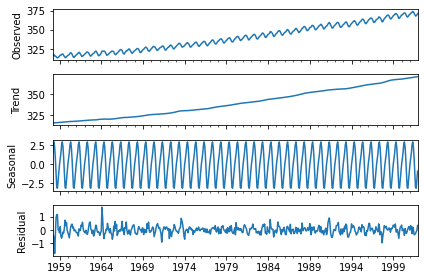

In [ ]:
result_sum.plot()
plt.show()

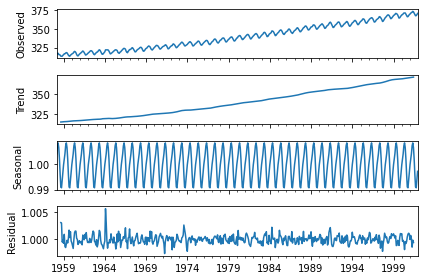

In [ ]:
result_mul.plot()
plt.show()

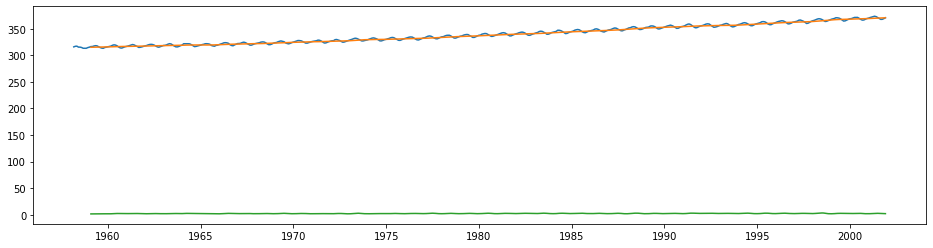

In [ ]:
rol_mean = datos2['co2'].rolling(window=12).mean() 
rol_std = datos2['co2'].rolling(window=12).std()
fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(datos2['co2'])
ax.plot(rol_mean)
ax.plot(rol_std)#la mean es baja sería weak stationary?

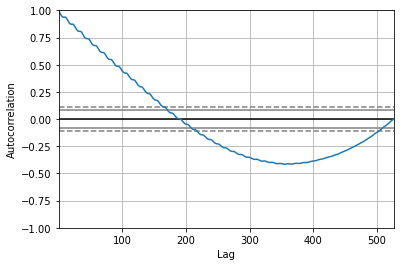

In [ ]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(datos2['co2'])

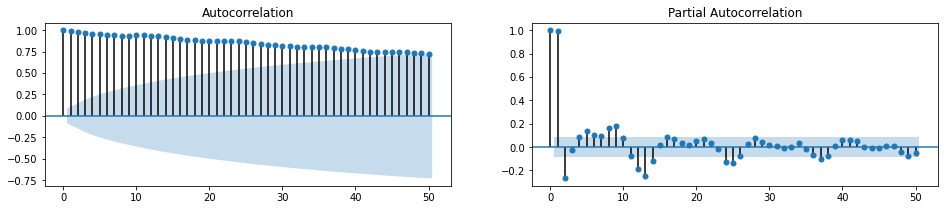

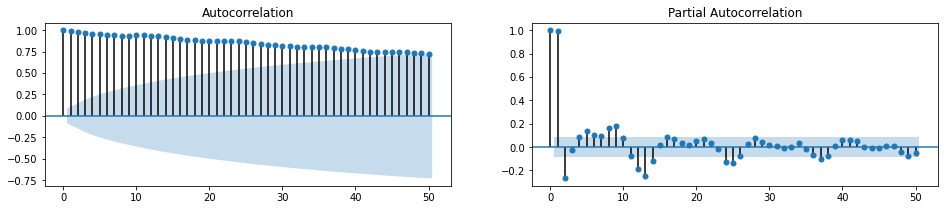

In [ ]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, axes = plt.subplots(1,2,figsize=(16,3))
plot_acf(datos2['co2'], lags=50, ax=axes[0])
plot_pacf(datos2['co2'], lags=50, ax=axes[1])

In [ ]:
def ApEn(U, m, r):
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for x_j in x if _maxdist(x_i, x_j) <= r]) / (N - m + 1.0) for x_i in x]
        return (N - m + 1.0)**(-1) * sum(np.log(C))

    N = len(U)
    return abs(_phi(m+1) - _phi(m))
print(ApEn(datos2['co2'], m=2, r=0.2*np.std(datos2['co2'])))    #Es baja la entropy es muy fácil de forecast Se nota no tiene gracia

0.2526011886159809


In [ ]:
from statsmodels.tsa.stattools import adfuller
def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [ ]:
def test_stationarity(timeseries, title):
    
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()

 > Is the de-trended data stationary ?
Test statistic = 2.360
P-value = 0.999
Critical values :
	1%: -3.4432119442564324 - The data is not stationary with 99% confidence
	5%: -2.8672126791646955 - The data is not stationary with 95% confidence
	10%: -2.569791324979607 - The data is not stationary with 90% confidence


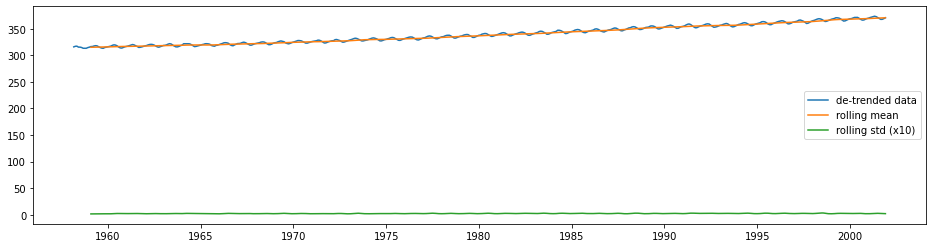

In [ ]:
test_stationarity(datos2['co2'],'de-trended data')
ADF_test(datos2['co2'],'de-trended data')

In [ ]:
#Saca la trend
y_detrend =  (datos2['co2'] - datos2['co2'].rolling(window=12).mean())/datos2['co2'].rolling(window=12).std()

 > Is the de-trended data stationary ?
Test statistic = -6.285
P-value = 0.000
Critical values :
	1%: -3.4436298692815304 - The data is  stationary with 99% confidence
	5%: -2.867396599893435 - The data is  stationary with 95% confidence
	10%: -2.5698893429241916 - The data is  stationary with 90% confidence


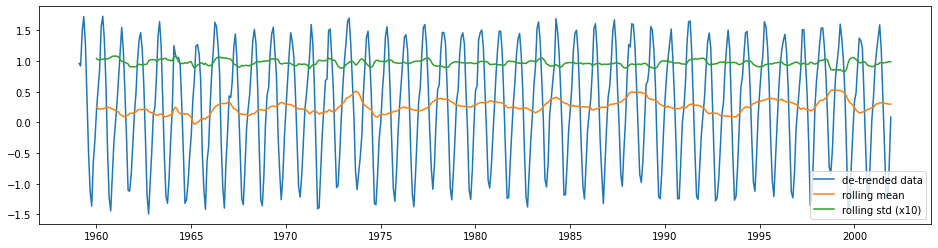

In [ ]:
test_stationarity(y_detrend,'de-trended data')
ADF_test(y_detrend,'de-trended data')

In [ ]:
#Saca seasonalitiy
y_12lag =datos2['co2'] - datos2['co2'].shift(12) 

 > Is the 12 lag differenced data stationary ?
Test statistic = -4.626
P-value = 0.000
Critical values :
	1%: -3.443496379464 - The data is  stationary with 99% confidence
	5%: -2.8673378563200003 - The data is  stationary with 95% confidence
	10%: -2.569858036 - The data is  stationary with 90% confidence


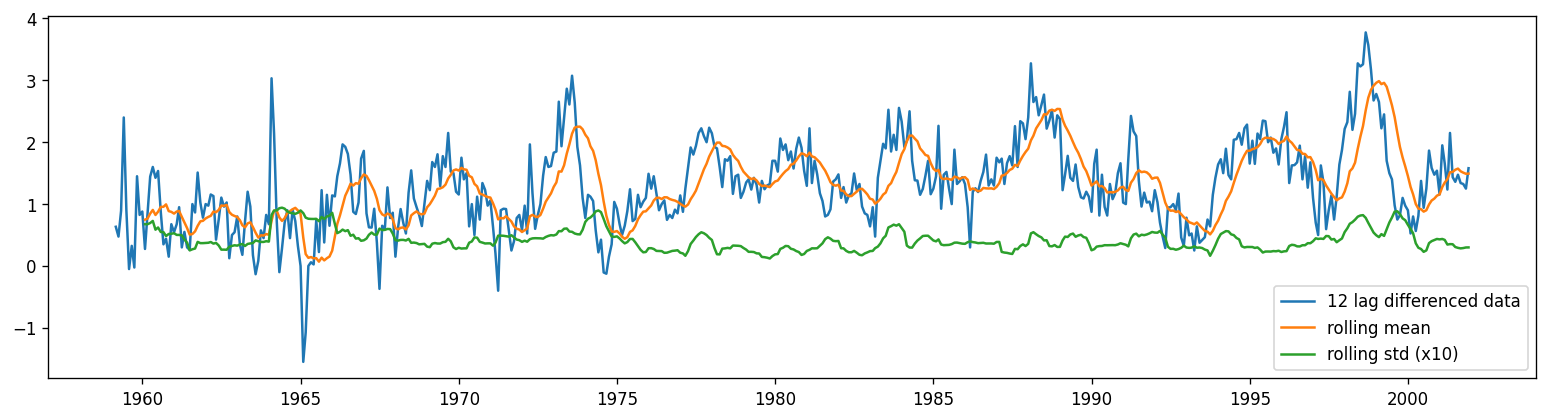

In [ ]:
test_stationarity(y_12lag,'12 lag differenced data')
ADF_test(y_12lag,'12 lag differenced data')

In [ ]:
#Hago la diference
y_12lag_detrend =  y_detrend - y_detrend.shift(12)

 > Is the 12 lag differenced de-trended data stationary ?
Test statistic = -8.078
P-value = 0.000
Critical values :
	1%: -3.4438213751870337 - The data is  stationary with 99% confidence
	5%: -2.867480869596464 - The data is  stationary with 95% confidence
	10%: -2.5699342544006987 - The data is  stationary with 90% confidence


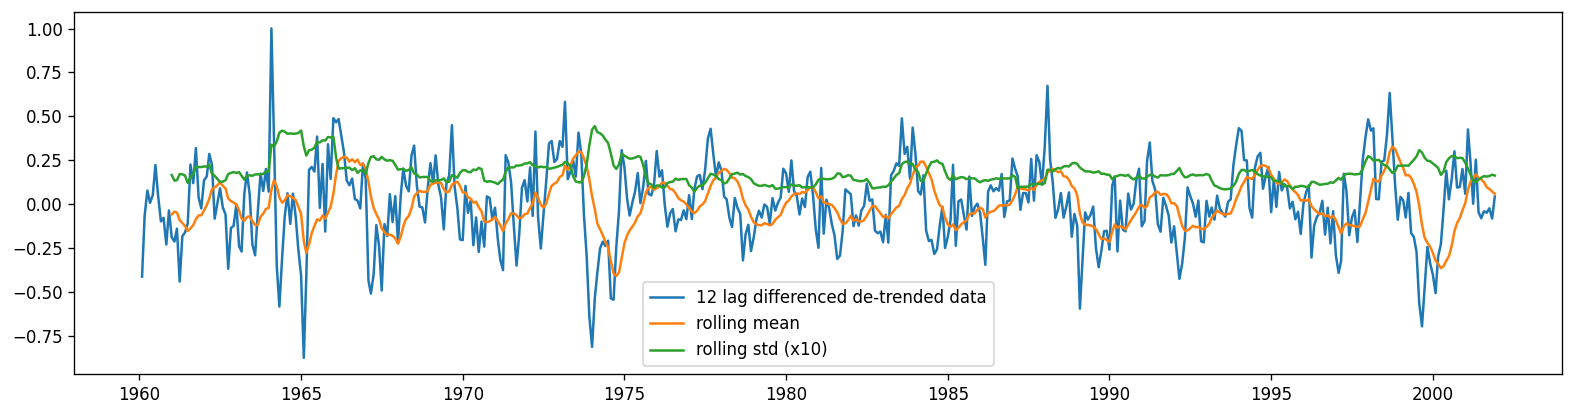

In [ ]:
test_stationarity(y_12lag_detrend,'12 lag differenced de-trended data')
ADF_test(y_12lag_detrend,'12 lag differenced de-trended data')#tremendamente stationarity

In [ ]:
y=y_12lag_detrend

In [ ]:
#Creo los conjuntos de pruebas 
y_to_train = y[:'2000-12-01'] # dataset to train
y_to_val = y['2000-12-01':] # last 
predict_date = len(y) - len(y[:'2001-01-01']) 


In [ ]:
#Hay que calcular d, p y q del ARIMA  pero también lo hago por grid serch
import itertools
p = d = q = range(0, 2)

# Genero all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generao all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]


In [ ]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y_to_train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:-59.456924271703215
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:-336.9898342958726
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:644.8817706968764
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:163.63269299723248
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:-16.954277682787506
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:-336.42454986002804
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:545.2659582047265
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:150.6503798846086
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:-235.36947280604477
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:-491.5445003251993
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:467.36887137376993
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:-24.35219140693279
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:-180.14641738371986
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:-491.5719936829542
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:373.9423169271476
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:-30.17084265835325
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:-204.47540699693485
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:-445.3395

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:622.6238356717498
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:-91.8687627179705
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:-236.67394463280363
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:-528.5321219732945
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:269.88345361431425
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:-103.0630368295796


In [ ]:
#uso (1,0,0), (1,0,1,12) en -564 AIC
mod = sm.tsa.statespace.SARIMAX(y_to_train,
                                order=(1, 0, 0),
                                seasonal_order=(1, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5949      0.028     21.070      0.000       0.540       0.650
ar.S.L12      -0.0020      0.002     -1.183      0.237      -0.005       0.001
ma.S.L12      -0.9197      0.029    -31.933      0.000      -0.976      -0.863
sigma2         0.0172      0.001     18.725      0.000       0.015       0.019


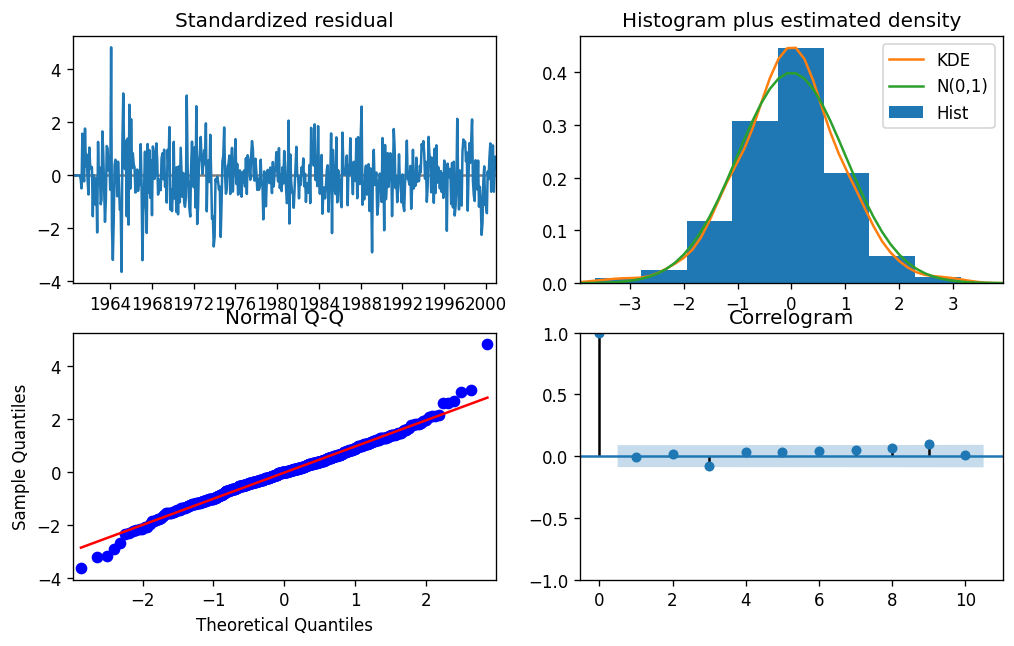

In [ ]:
results.plot_diagnostics(figsize=(10, 6))
plt.show()

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=False)
pred_ci = pred.conf_int()

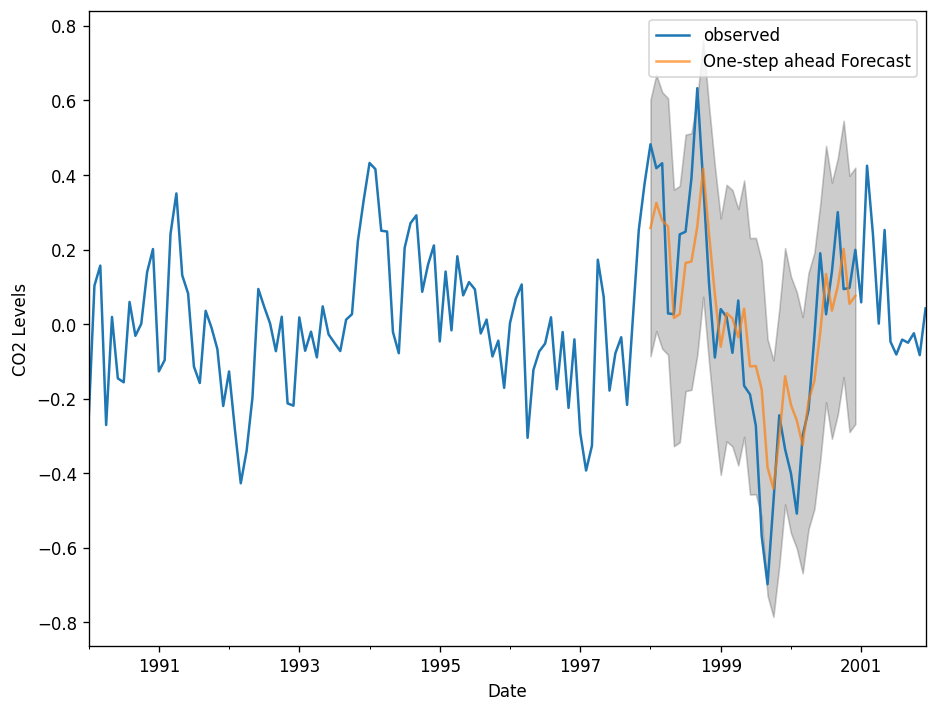

In [ ]:
ax = y['1990':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()

plt.show()

In [ ]:
y_forecasted = pred.predicted_mean
y_truth = y_to_train['1998-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.03


In [ ]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

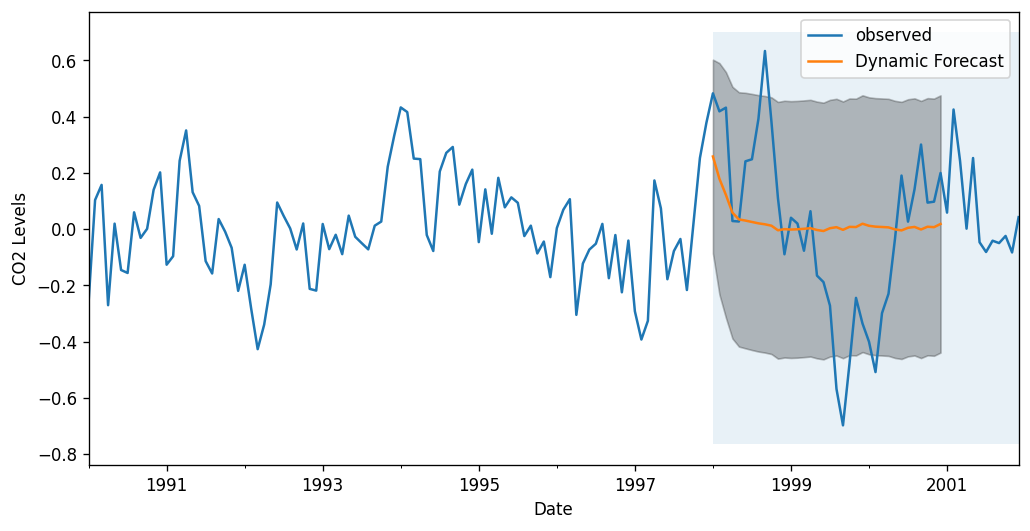

In [ ]:
ax = y['1990':].plot(label='observed', figsize=(10,5))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1998-01-01'), y.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()

In [ ]:
# Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean
y_truth = y_to_train['1998-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.09


In [ ]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=10)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

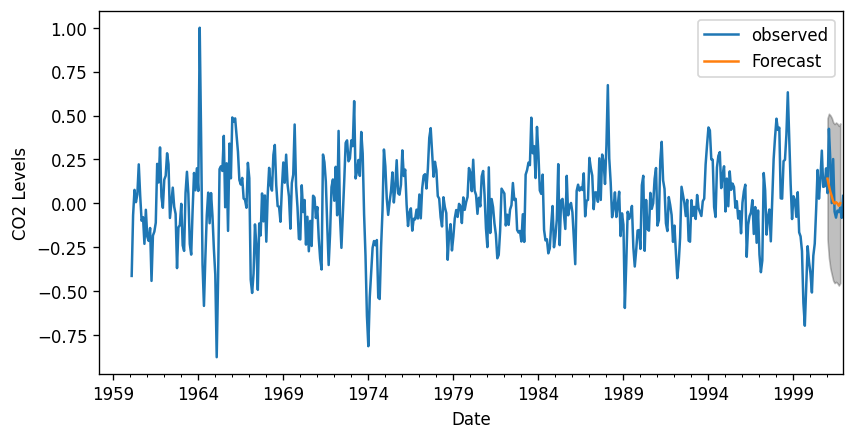

In [ ]:
ax = y.plot(label='observed', figsize=(8,4))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()